In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

In [2]:
from transformers import (
    GPT2Config,
    GPT2Tokenizer,
    GPT2LMHeadModel,
)


/home/cgagne/cvar_generation/conda_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
modelname = '../models/pretrained/gpt2-large/'
config = GPT2Config.from_pretrained(modelname)
tokenizer = GPT2Tokenizer.from_pretrained(modelname)

In [4]:
import sys
sys.path.append('../')
from rl_learner import TD_Learner
import torch
import pickle
device = 'cpu'

### Code 

In [5]:
def colored(r, g, b, text):
    return "\033[38;2;{};{};{}m{} \033[38;2;255;255;255m".format(r, g, b, text)
  
    
def create_strings(t, p, pd, diff, tokens, selected_tokens):
    probs_str = colored(0, 0, 0, 'p=\t')
    dis_probs_str = colored(0, 0, 0, 'pd=\t')
    tokens_str = 't=\t'
    
    for pi, pdi, di, tok in zip(p[t,:], pd[t,:], diff[t,:], tokens[t,:]):
        pis=str(np.round(pi,2))
        pis = colored(0, 0, 0, pis)
        probs_str+=pis
        probs_str+='\t'

        pis=str(np.round(pdi,2))
        if di<-0.05:
            pis = colored(200, 0, 0, pis)
        elif di<-0.025:
            pis = colored(100, 0, 0, pis)
        elif di>0.05:
            pis = colored(0, 200, 0, pis)
        elif di>0.025:
            pis = colored(0, 100, 0, pis)
        else:
            pis = colored(0, 0, 0, pis)
        dis_probs_str+=pis
        dis_probs_str+='\t'
        
        tok = tok.replace('\n','/n')
        if tok.strip()==selected_tokens[t]:
            tok = colored(0, 0, 200, tok)
        else:
            tok = colored(0, 0, 0, tok)
        tokens_str += tok
        tokens_str += '\t'

    #if t==0:
    #    import ipdb; ipdb.set_trace()

    return(probs_str, dis_probs_str, tokens_str)

def create_cvar_strings(t, cvars, sel_alphas=[0,0.05,0.25,0.55,0.75,1.]):
    cvar_str = ''
    for alpha in sel_alphas:
        cvar_str+=str(alpha)+'\t'
        c = cvars[t,:,alpha_set.index(alpha)]
        for ci in c:
            cvar_str+=str(np.round(ci,2))
            cvar_str+='\t'
        cvar_str+='\n'
    return(cvar_str)

def create_quantile_strings(t, quantiles, sel_taus=[0.05,0.25,0.55,0.75,0.95]):
    q_str = ''
    for tau in sel_taus:
        q_str+=str(tau)+'\t'
        c = quantiles[t,:,taus_set.index(tau)]
        for ci in c:
            q_str+=str(np.round(ci,2))
            q_str+='\t'
        q_str+='\n'
    return(q_str)

def print_example(i, alpha=0.05):
    
    sentence = sentences_storage[alpha][i]
    selected_tokens = [t.replace('Ġ','') for i,t in enumerate(tokenizer.tokenize(sentence))]
    alphas_per_seq = alpha_storage[alpha][i]
    prompt = prompt_storage[alpha][i]
    n_tokens = len(selected_tokens)
    pd = np.array(pd_storage[alpha][i])
    p = np.array(p_storage[alpha][i])
    tokens = np.array(token_storage[alpha][i])
    diff = pd-p
    cvars = np.array(cvar_storage[alpha][i])
    quantiles = np.array(quantile_storage[alpha][i])
    successes = success_storage[alpha][i]

    assert p.shape[0]==n_tokens

    print(f'prompt: {prompt}')
    print(f'{sentence}')
    print()
    partial_sentence = ''
    for t, tok in enumerate(selected_tokens):

        probs_str, dis_probs_str, tokens_str = create_strings(t, p, pd, diff, tokens, selected_tokens)

        cvar_str = create_cvar_strings(t, cvars, sel_alphas=[0,0.05,0.25,0.55,0.75,1.])
        cvar_str = colored(0,0,0,cvar_str)

        q_str = create_quantile_strings(t, quantiles, sel_taus=[0.05,0.25,0.55,0.75,0.95])
        if successes[t]:
            q_str = colored(0,0,0,q_str)
        else:
            q_str = colored(255,0,0,q_str)

        print(colored(0, 0, 0, '--------'))
        print(colored(0, 0, 0, f'({str(np.round(alphas_per_seq[t],2))}) '+partial_sentence))
        print(colored(0, 0, 0, '--------'))
        print(tokens_str)
        print(probs_str)
        print(dis_probs_str)
        print()
        print(q_str)
        print()
        print(cvar_str)
        print()

        partial_sentence+=tok+' '

### Generating Sentences using CVaR

In [6]:
import sys
sys.path.append('../')
from rl_learner import TD_Learner
import torch
import pickle
from cvar_helpers import calc_cvar_from_samples
device = 'cpu'

#### load full training data 

In [7]:
file = '../data/results/single_sentences_IYou_3/ends.txt'
f = open(file, "r")
sentences = f.readlines()
sentences = np.array([s.replace('\n','') for s in sentences])
rewards =  np.array([float(s.split('r=')[-1]) for s in sentences])

In [8]:
len(sentences)

73566

#### load cvar generated sentences (topk=10)

In [10]:
sentences_cvar = {}
rewards_cvar = {}
alphas = [0.05]
top_k =10

for alpha in alphas:

    file = f'../data/results/single_sentences_IYou_3/ends_cvar_{alpha}_{top_k}.txt'
    f = open(file, "r")
    sentences_cvar[alpha] = np.array([s.replace('\n','') for s in f.readlines()])
    rewards_cvar[alpha] =  np.array([float(s.split('r=')[-1]) for s in sentences_cvar[alpha]])
    

In [11]:
alpha_storage = {}
p_storage = {}
pd_storage = {}
sentences_storage = {}
sentences_storage_full = {}
rewards_storage = {}
token_storage = {}
cvar_storage = {}
prompt_storage = {}
quantile_storage = {}
success_storage = {}

for alpha in [0.05]:

    file = f'../data/results/single_sentences_IYou_3/cvar_output_{alpha}_{top_k}.pkl'
    
    loaded = pickle.load(open(file,'rb'))
    alpha_storage[alpha] = loaded['alphas']
    p_storage[alpha] = loaded['p_storage']
    pd_storage[alpha] = loaded['pd_storage']
    sentences_storage[alpha] = loaded['sentences']
    sentences_storage_full[alpha] = loaded['sentences_full']
    rewards_storage[alpha] = loaded['rewards']
    token_storage[alpha] = loaded['token_storage']
    cvar_storage[alpha] = loaded['cvar_storage']
    quantile_storage[alpha] = loaded['quantile_storage']
    prompt_storage[alpha]= loaded['prompt_storage']
    success_storage[alpha] = loaded['successes']

#### Plot the distribution

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


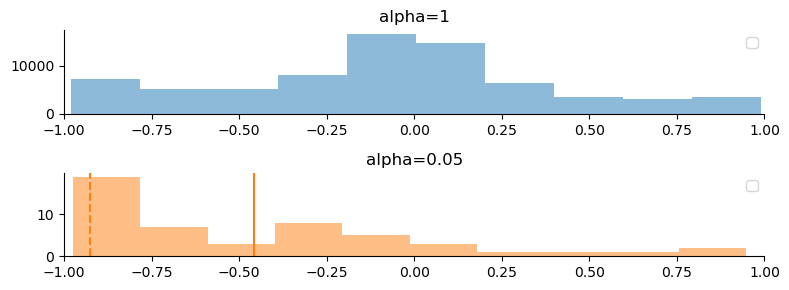

In [12]:
stem = ""
sel = np.array([s.startswith(stem) for s in sentences]).astype('bool')

fig,axes = plt.subplots(len(alphas)+1, 1, figsize=(8,3*len(alphas)), dpi=100)

plt.sca(axes[0])
plt.hist(rewards[sel], alpha=0.5, label=f'{stem}', density=False)

plt.legend()
sns.despine()
plt.xlim([-1,1])
plt.title(f'alpha=1')

for a, alpha in enumerate(alphas[::-1]):
    
    plt.sca(axes[a+1]) 
    sel_cvar = np.array([s.startswith(stem) for s in sentences_cvar[alpha]]).astype('bool')
    plt.hist(rewards_cvar[alpha][sel_cvar], alpha=0.5, color=sns.color_palette()[a+1],
             label=f'{stem}',density=False)
    
    
    
    _, cvar = calc_cvar_from_samples(rewards[sel], alpha)
    mean = np.nanmean(rewards_cvar[alpha][sel_cvar])
    plt.axvline(x=cvar, color=sns.color_palette()[a+1], linestyle='--')
    plt.axvline(x=mean, color=sns.color_palette()[a+1])
    plt.xlim([-1,1])
    plt.title(f'alpha={alpha}')
    
plt.legend()
plt.tight_layout()

In [13]:
sentences
for sentence in sentences_cvar[0.05]:
    if sentence not in sentences:
        print(sentence)

In [14]:
sentences
for sentence in sentences_cvar[0.05]:
    #if sentence not in sentences:
    print(sentence)

I'm so tired of seeing negativity here. r=-0.974
I am so tired. r=-0.945
I don't understand what happened. r=-0.935
…I'm going to fail that test. r=-0.930
I might fail the test. r=-0.915
I might fail the test. r=-0.915
I might fail the test. r=-0.915
I might fail the test. r=-0.915
I might die. r=-0.885
I'm sorry I'm just so disorganized. r=-0.877
I'm sorry for the hole in my heart. r=-0.874
You might die. r=-0.872
I can't sleep. r=-0.847
I can't sleep. r=-0.847
I was so tired. r=-0.846
I'm not going to make the grade. r=-0.818
The doctors told me that you couldn't afford surgery because of Medicaid, Linton wrote. r=-0.808
I need surgery. r=-0.802
I need surgery. r=-0.802
I'm tired. r=-0.778
My stomach feels a little tight. r=-0.773
You need surgery. r=-0.744
: You're not ready for matriculation at Harvard. r=-0.723
You were late for class. r=-0.685
I didn't sleep a wink. r=-0.674
You don't have any money. r=-0.647
I don't have insurance. r=-0.576
You didn't sleep in your underwear. r=

In [15]:
#rewards_storage[0.05]

In [16]:
sentences
for s, sentence in enumerate(sentences_storage[0.05]):
    #if sentence not in sentences:
    print(s, sentence)

0 I might fail the test.
1 : You're not ready for matriculation at Harvard.
2 You need a doctor.
3 , really the math test.
4 I need surgery.
5 I am so tired.
6 I didn't sleep a wink.
7 You got a little too much coffee, she began.
8 I might fail the test.
9 I'm sorry for the hole in my heart.
10 It was the first time I were alive.
11 … I need to live with two people.
12 … I'm at the supermarket in the morning, just having fun.
13 I'm so tired of seeing negativity here.
14 I can't sleep.
15 I was going to go to the grocery store.
16 You took the stairs.
17 You didn't sleep in your underwear.
18 I don't understand what happened.
19 … They told me: 'You've had your baby, you can take it.
20 , really the math test.
21 The answer is C.
22 I might fail the test.
23 I might die.
24 You need surgery.
25 …I'm going to fail that test.
26 You don't have any money.
27 And now you are out of the house.
28 I'm tired.
29 I might fail the test.
30 You're tired, but you love your job.
31 I'm sorry I'm j

#### Printing P-distributions

In [17]:
n_quantiles = 10
taus = (2 * np.arange(n_quantiles) + 1) / (2.0 * n_quantiles)
alpha_set = list(np.append(np.insert(taus, 0, 0), 1)) # add zero, one
taus_set = list(taus)
taus_set

[0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]

In [18]:
print_example(48, alpha=0.05)

prompt: I went to the grocery store. I walked my dog to the park. I woke up early.
The first thing I saw was two beautiful crayfish.

-------- 
(0.05)  
-------- 
t=	I 	… 	, 	And 	The 	My 	When 	. 	It 	: 	
p=	 0.73 	0.06 	0.05 	0.04 	0.03 	0.02 	0.02 	0.02 	0.02 	0.02 	
pd=	 0.73 	0.06 	0.05 	0.03 	0.03 	0.08 	0.0 	0.0 	0.02 	0.02 	

0.05	-0.64	-0.57	-0.51	-0.49	-0.56	-0.78	-0.38	-0.03	-0.69	-0.51	
0.25	-0.25	-0.31	-0.29	-0.27	-0.32	-0.41	-0.2	-0.03	-0.36	-0.28	
0.55	-0.01	-0.09	-0.1	-0.09	-0.12	-0.15	-0.06	-0.0	-0.07	-0.1	
0.75	0.11	0.04	0.01	0.02	0.0	-0.01	0.02	0.02	0.12	0.01	
0.95	0.34	0.3	0.25	0.24	0.25	0.31	0.19	0.07	0.5	0.24	
 

0	-0.64	-0.57	-0.51	-0.49	-0.56	-0.78	-0.38	-0.03	-0.69	-0.51	
0.05	-0.64	-0.57	-0.51	-0.49	-0.56	-0.78	-0.38	-0.03	-0.69	-0.51	
0.25	-0.38	-0.4	-0.37	-0.35	-0.4	-0.54	-0.26	-0.03	-0.48	-0.37	
0.55	-0.22	-0.27	-0.25	-0.24	-0.28	-0.37	-0.17	-0.02	-0.3	-0.25	
0.75	-0.14	-0.2	-0.19	-0.18	-0.22	-0.28	-0.13	-0.01	-0.2	-0.19	
1.0	-0.08	-0.13	-0.14	-0.13	-0.16	-

### Load GPT-2

In [21]:
model = GPT2LMHeadModel.from_pretrained(modelname)
device='cpu'

### Printing examples from the Quantile model

[0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95]
[-0.25 -0.17 -0.12 -0.09 -0.07 -0.05 -0.02 -0.01  0.02  0.1 ]
[-0.36 -0.21 -0.13 -0.08 -0.05 -0.02  0.02  0.06  0.12  0.21]
[-0.26 -0.17 -0.11 -0.06 -0.03  0.    0.03  0.06  0.1   0.18]
[-0.29 -0.15 -0.1  -0.07 -0.04 -0.02  0.01  0.03  0.07  0.17]
[-0.29 -0.19 -0.12 -0.09 -0.05 -0.02  0.01  0.06  0.12  0.25]
[-0.24 -0.11 -0.05 -0.02  0.01  0.03  0.05  0.08  0.14  0.23]
[-0.44 -0.27 -0.19 -0.13 -0.09 -0.04  0.    0.05  0.12  0.24]
[-0.36 -0.19 -0.12 -0.07 -0.03  0.01  0.05  0.09  0.17  0.29]
[-0.36 -0.23 -0.15 -0.09 -0.03  0.02  0.07  0.13  0.21  0.32]
[-0.3  -0.19 -0.13 -0.1  -0.07 -0.04 -0.01  0.02  0.06  0.18]
[-0.33 -0.21 -0.16 -0.12 -0.09 -0.05 -0.02  0.02  0.07  0.21]
[-0.36 -0.21 -0.14 -0.1  -0.06 -0.03 -0.    0.04  0.1   0.2 ]
[-0.21 -0.14 -0.09 -0.06 -0.03 -0.01  0.02  0.05  0.1   0.21]
[-0.38 -0.21 -0.14 -0.09 -0.04  0.    0.03  0.07  0.12  0.22]
[-0.31 -0.17 -0.11 -0.07 -0.04 -0.01  0.03  0.08  0.14  0.26]
[-0.35 -0.2  -0.12

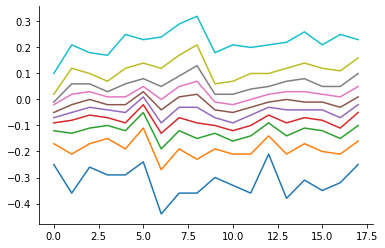

In [44]:
example = 'The first thing I saw'

# print true quantiles 
sel = np.array([s.startswith(example) for s in sentences]).astype('bool')
thetas = [np.quantile(rewards[sel].squeeze(), q) for q in taus]
print(np.round(thetas,2))

theta_hats_lasts = []
for epoch in range(5,95,5):

    hidden_dim =101
    n_quantiles = 10
    filename=f'../data/results/single_sentences_IYou_3/quantile_learner_101_0.1/log_quantile_learner_epoch{epoch}.pkl'

    # load quantile network 
    Z_network = TD_Learner(config.n_embd, n_quantiles, hidden_dim=hidden_dim)

    Z_network.load_state_dict(torch.load(filename.replace('log_',''),
                                        map_location=torch.device('cpu')))
    
    # get hidden states 
    inputs = tokenizer(example, return_tensors='pt').to(device)
    with torch.no_grad():
        output = model(input_ids=inputs['input_ids'],
                       attention_mask=inputs['attention_mask'],
                       output_hidden_states=True)
        states = output['hidden_states'][-1]
        
        # get quantiels 
        theta_hats = Z_network(states).detach().cpu().numpy().round(2)
        theta_hats_last = theta_hats[:,-1,:].squeeze()
    print(theta_hats_last)
    theta_hats_lasts.append(theta_hats_last)
    
plt.plot(np.array(theta_hats_lasts));
sns.despine()
    